In [1]:
import os
import sys
sys.path.append(os.path.join('..', '..'))

from scripts.data_loaders.TIMIT import TIMITDataset
from scripts.data_loaders.EpaDB import EpaDBDataset
from scripts.data_loaders.PSST import PSSTDataset
from scripts.data_loaders.SpeechOcean import SpeechOceanDataset

from scripts.ipa_transcription.wav2vec2 import transcribe_batch, clear_cache, load_model
from scripts.eval.evaluate import evaluate

import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

from IPython.display import clear_output
clear_output()

In [2]:
TestSet = namedtuple('TestSet', ['name', 'data'])

testsets = [
    TestSet('TIMIT', TIMITDataset(split='test')),
    TestSet('EpaDB', EpaDBDataset(split='test')),
    TestSet('PSST', PSSTDataset(split='test', force_offline=True)),
    TestSet('SpeechOcean', SpeechOceanDataset(split='test')),
]

psstdata INFO: Loaded data version local at /Users/alex/Desktop/CS/Startups/Koel/ML/notebooks/Eval/../../scripts/data_loaders/../../.data/psst-data


In [ ]:
Model = namedtuple('Model', ['name', 'model_id'])

models = [
    Model('Facebook 53', "facebook/wav2vec2-xlsr-53-espeak-cv-ft"),
    Model('Facebook 60', "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    Model('Koel Labs B0', "KoelLabs/xlsr-timit-b0"),
    Model('Ginic', "ginic/data_seed_4_wav2vec2-large-xlsr-buckeye-ipa"),
    Model('Speech31', "speech31/XLS-R-300m-english-ipa"),
    Model('Vitouphy', "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"),
    Model('Taguchi', "ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000"),
    Model('Rubino', "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"),
]

In [11]:
OUTPUT_PATH = os.path.join('..', '..', '.data', 'ipa_predictions.csv')

if os.path.exists(OUTPUT_PATH):
    output_df = pd.read_csv(OUTPUT_PATH)
else:
    output_df = pd.DataFrame(columns=[
        'dataset',
        'model_name',
        'ground_truth',
        "prediction"
    ])

In [12]:
BATCH_SIZE = 4
for model_name, model_id in models:
    clear_cache()
    model, processor = None, None
    for dataset_name, dataset in testsets:
        print(model_name, dataset_name, '...', end=" ")

        # if dataset and model combo already in df, skip
        if ((output_df['dataset'] == dataset_name) & (output_df['model_name'] == model_name)).any():
            print("already done")
            continue

        if model is None or processor is None:
            model, processor = load_model(model_id)

        amount = len(dataset)
        for i in range(0, amount, BATCH_SIZE):
            clear_cache()
            size = min(BATCH_SIZE, amount - i)
            transcriptions = transcribe_batch(dataset[i:i+size], model, processor)
            for j in range(size):
                output_df = pd.concat([output_df, pd.DataFrame([[
                    dataset_name,
                    model_name,
                    dataset[i + j][0],
                    transcriptions[j]
                ]], columns=output_df.columns)])

        output_df.to_csv(OUTPUT_PATH, index=False)
        print("done")

Facebook 53 TIMIT ... already done
Facebook 53 EpaDB ... already done
Facebook 53 PSST ... already done
Facebook 53 SpeechOcean ... already done
Facebook 60 TIMIT ... already done
Facebook 60 EpaDB ... already done
Facebook 60 PSST ... already done
Facebook 60 SpeechOcean ... already done
Koel Labs B0 TIMIT ... already done
Koel Labs B0 EpaDB ... already done
Koel Labs B0 PSST ... already done
Koel Labs B0 SpeechOcean ... already done
Ginic TIMIT ... already done
Ginic EpaDB ... already done
Ginic PSST ... already done
Ginic SpeechOcean ... already done
Speech31 TIMIT ... already done
Speech31 EpaDB ... already done
Speech31 PSST ... already done
Speech31 SpeechOcean ... already done
Vitouphy TIMIT ... already done
Vitouphy EpaDB ... already done
Vitouphy PSST ... already done
Vitouphy SpeechOcean ... already done
Taguchi TIMIT ... already done
Taguchi EpaDB ... done
Taguchi PSST ... done
Taguchi SpeechOcean ... done
Rubino TIMIT ... done
Rubino EpaDB ... done
Rubino PSST ... done
Rubi

In [13]:
output_df[output_df['prediction'].isna()]

,dataset,model_name,ground_truth,prediction
19386,SpeechOcean,Koel Labs B0,ðeɪdɪdnʌtsiðɛmɛˈnimɔ,NaN
19388,SpeechOcean,Koel Labs B0,ʃimʌstbimeɪdtʌsteɪ,NaN
23493,PSST,Ginic,sksk,NaN
24415,SpeechOcean,Ginic,hɪʌɪzmɛˈɝɪsʃuz,NaN
25470,SpeechOcean,Ginic,ðeɪdɪdnʌtsiðɛmɛˈnimɔ,NaN
25472,SpeechOcean,Ginic,ʃimʌstbimeɪdtʌsteɪ,NaN
37640,SpeechOcean,Vitouphy,ʃimʌstbimeɪdtʌsteɪ,NaN


In [14]:
# drop failed rows
output_df.dropna(inplace=True)

In [15]:
output_df[["per", "fer"]] = output_df.parallel_apply(lambda x: pd.Series(evaluate(x['ground_truth'], x['prediction'], simplify=True)), axis=1) # type: ignore

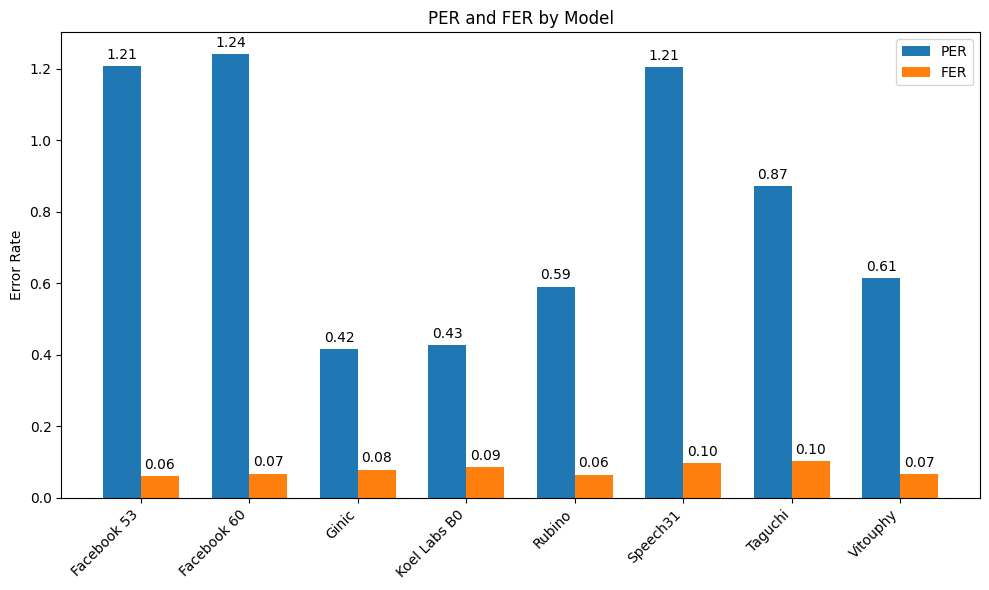

In [25]:
# plot per and fer by model as bar chart with two bars per model (one for per and one for fer)
# models = ['Facebook 53', 'Facebook 60', 'Koel Labs B0', 'Vitouphy']
models = sorted(output_df['model_name'].unique())
agg_df = output_df[output_df["model_name"].isin(models)].groupby("model_name")[["per", "fer"]].mean().reset_index()
x = np.arange(len(agg_df["model_name"]))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, agg_df["per"], width, label='PER')
bars2 = ax.bar(x + width/2, agg_df["fer"], width, label='FER')

# Add labels and title
ax.set_ylabel('Error Rate')
ax.set_title('PER and FER by Model')
ax.set_xticks(x)
ax.set_xticklabels(agg_df["model_name"], rotation=45, ha="right")
ax.legend()

# Optionally add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

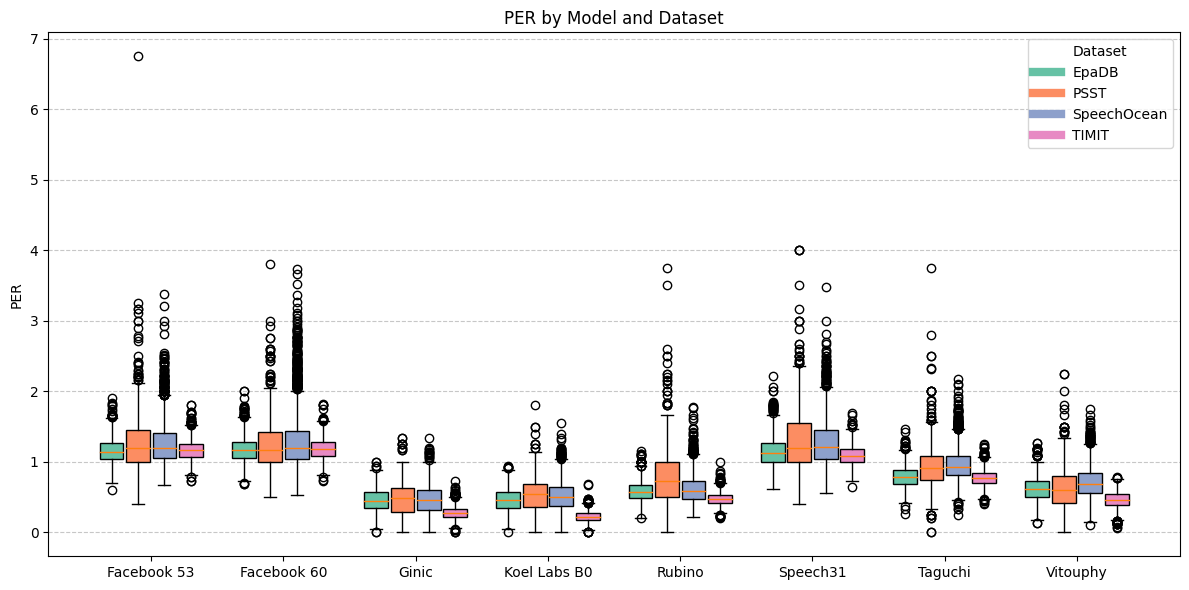

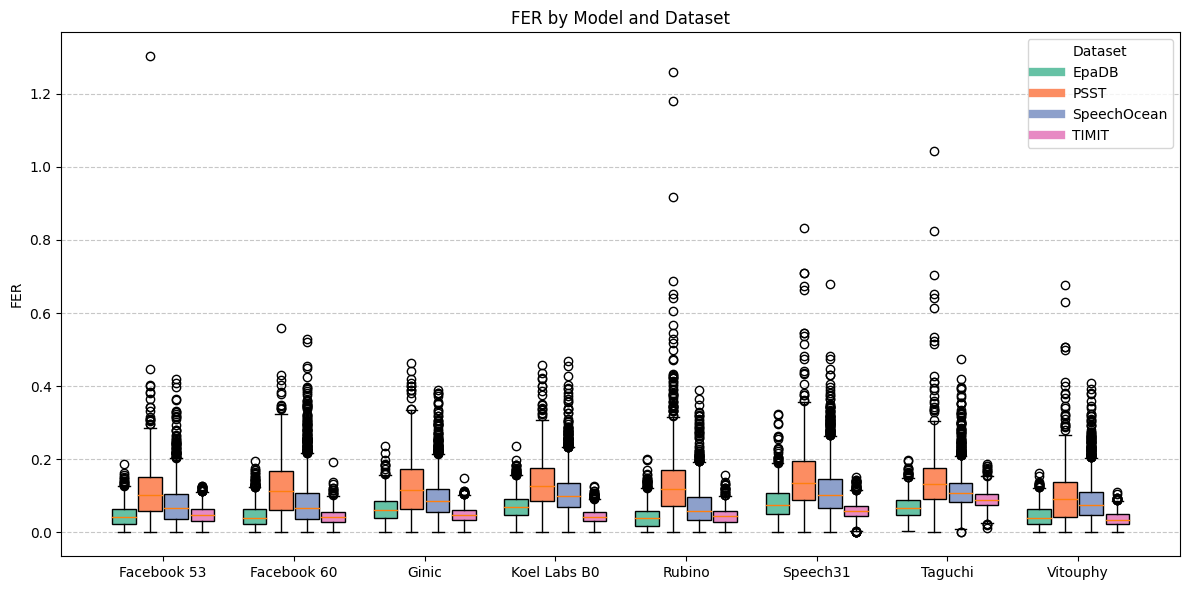

In [24]:
# two box plots (one for per and one for fer) for each model and dataset combo
# models = ['Facebook 53', 'Facebook 60', 'Koel Labs B0', 'Vitouphy'] 
models = sorted(output_df['model_name'].unique())
datasets = sorted(output_df['dataset'].unique())
colors = sns.color_palette("Set2", len(datasets))

# Define helper function to create grouped boxplots
def plot_grouped_boxplots(metric: str, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    positions = []
    labels = []
    data = []
    current_pos = 0
    width = 4 / len(datasets)  # width per box within each group

    for model in models:
        for i, dataset in enumerate(datasets):
            subset = output_df[(output_df['model_name'] == model) & (output_df['dataset'] == dataset)]
            if not subset.empty:
                data.append(subset[metric].values)
                pos = current_pos + i * width
                positions.append(pos)
                labels.append(model if i == len(datasets) // 2 else "")  # Label model only once
        current_pos += width * len(datasets) + 1  # Add spacing between models

    # Flatten and plot each box individually with appropriate color
    bp = ax.boxplot(data, positions=positions, widths=width*0.9, patch_artist=True, manage_ticks=False)

    # Color boxes
    for i, box in enumerate(bp['boxes']):
        dataset_index = i % len(datasets)
        box.set(facecolor=colors[dataset_index])

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors] # type: ignore
    ax.legend(handles, datasets, title="Dataset")

    ax.set_title(title)
    ax.set_ylabel(metric.upper())
    ax.set_xticks(
        [np.mean(positions[i*len(datasets):(i+1)*len(datasets)]) for i in range(len(models))]
    )
    ax.set_xticklabels(models, rotation=0, ha='center')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot both PER and FER
plot_grouped_boxplots("per", "PER by Model and Dataset")
plot_grouped_boxplots("fer", "FER by Model and Dataset")

In [18]:
output_df.groupby(['model_name'])[['per', 'fer']].mean()

,per,fer
model_name,,
Facebook 53,1.207293,0.061530
Facebook 60,1.239977,0.067329
Ginic,0.415876,0.078702
Koel Labs B0,0.427174,0.085613
Rubino,0.590497,0.064803
Speech31,1.205542,0.096682
Taguchi,0.872841,0.101490
Vitouphy,0.614200,0.065431


In [19]:
output_df.groupby(['dataset'])[['per', 'fer']].mean()

,per,fer
dataset,,
EpaDB,0.800614,0.058393
PSST,0.896687,0.127919
SpeechOcean,0.891643,0.092783
TIMIT,0.760926,0.051674


In [20]:
output_df.groupby(['dataset', 'model_name'])[['per', 'fer']].mean()

per       fer
dataset     model_name                      
EpaDB       Facebook 53   1.161449  0.045940
            Facebook 60   1.176776  0.045152
            Ginic         0.460312  0.063877
            Koel Labs B0  0.460014  0.071854
            Rubino        0.590945  0.042929
            Speech31      1.148402  0.082301
            Taguchi       0.790197  0.069814
            Vitouphy      0.616820  0.045274
PSST        Facebook 53   1.264850  0.111158
            Facebook 60   1.227469  0.118150
            Ginic         0.476107  0.122758
            Koel Labs B0  0.545545  0.134380
            Rubino        0.778474  0.140527
            Speech31      1.311881  0.150117
            Taguchi       0.942835  0.143223
            Vitouphy      0.625692  0.103028
SpeechOcean Facebook 53   1.265401  0.075018
            Facebook 60   1.310422  0.081357
            Ginic         0.469891  0.094497
            Koel Labs B0  0.515192  0.107994
            Rubino        0.615541  0.069696
            Speech31      1.281084  0.114367
            Taguchi       0.963376  0.114212
            Vitouphy      0.711350  0.085132
TIMIT       Facebook 53   1.170404  0.047795
            Facebook 60   1.188216  0.043561
            Ginic         0.279218  0.049456
            Koel Labs B0  0.226349  0.043963
            Rubino        0.480146  0.044659
            Speech31      1.095548  0.060610
            Taguchi       0.773984  0.090338
            Vitouphy      0.464065  0.036889